In [1]:
import numpy as np

# Imports nécessaires pour construire un modèle LeNet 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Rescaling, BatchNormalization

# Pour importer le datasets
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Pour la compilation du modèle
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Pour visualiser les performances
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline


print(tf.__version__)
tf.keras.backend.clear_session()
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Chargement du dataset
img_size = (224, 224)  # Taille cible
batch_size = 128

train_ds = image_dataset_from_directory(
    "/mnt/c/Users/karim/rakuten/images/data_clean/images_deep/sample",
    image_size=img_size,
    batch_size=batch_size,
    subset="training",
    validation_split=0.2,
    seed=42
)

val_ds = image_dataset_from_directory(
    "/mnt/c/Users/karim/rakuten/images/data_clean/images_deep/sample",
    image_size=img_size,
    batch_size=batch_size,
    subset="validation",
    validation_split=0.2,
    seed=42
)


2025-03-15 10:19:18.010418: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742030358.175533    1047 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742030358.227122    1047 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742030358.618700    1047 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742030358.618770    1047 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742030358.618772    1047 computation_placer.cc:177] computation placer alr

2.19.0
Num GPUs Available:  1
Found 6851 files belonging to 3 classes.
Using 5481 files for training.


I0000 00:00:1742030373.200670    1047 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 6851 files belonging to 3 classes.
Using 1370 files for validation.


In [21]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
])

# Normalisation 
normalization_layer = Rescaling(1./255)

# Première couche de convolution
conv_30 = Conv2D(
    filters=30,                    # Nombre de filtres
    kernel_size=(5, 5),            # Dimensions du noyau
    padding='valid',               # Mode de Dépassement
    activation='relu',             # Fonction d'activation
)

# Première couche de pooling
max_pool_1 = MaxPooling2D(pool_size=(2, 2),)

# Deuxième couche de convolution
conv_16 = Conv2D(
    filters=16,                    
    kernel_size=(3, 3),          
    padding='valid',             
    activation='relu',
)

# Deuxième couche de pooling
max_pool_2 = MaxPooling2D(pool_size=(2, 2),)

# Couche de dropout
dropout = Dropout(0.2)

# Couche de Flatten
flatten = Flatten()

# Première couche dense
dense_128 = Dense(
    units=128,
    activation='relu',
)

# Couche de sortie
dense_softmax = Dense(
    units=3,
    activation='softmax',
)


early_stopping = EarlyStopping(
                                patience=7, 
                                min_delta=0.01, 
                                mode='min',
                                monitor='val_loss',
                                restore_best_weights=True
                            )

reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_loss",
                                    patience=3,
                                    min_delta=0.01,
                                    factor=0.5, 
                                    cooldown=4)

In [8]:
###  Architecture du model ###

inputs = Input(shape=(224, 224, 3))

# Extraction des caractéristqiues
x = normalization_layer(inputs)
x = conv_30(x)
x = max_pool_1(x)
x = conv_16(x)
x = max_pool_2(x)
x = dropout(x)

# Applatissement 
x = flatten(x)

# Couches dense pour la prédiction 
x = dense_128(x)
outputs = dense_softmax(x)

lenet = Model(inputs=inputs, outputs=outputs)

lenet.compile(loss='sparse_categorical_crossentropy',  # fonction de perte
              optimizer='adam',                 # algorithme de descente de gradient
              metrics=['accuracy'])             # métrique d'évaluation

lenet_history = lenet.fit(train_ds,           # données
                           validation_data=val_ds,
                           epochs=15)             # taille des batchs

Epoch 1/15


I0000 00:00:1741970343.693711    1408 service.cc:152] XLA service 0x128cddf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741970343.693761    1408 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2025-03-14 17:39:03.762039: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


 2/43 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.3496 - loss: 3.5276 

I0000 00:00:1741970353.725373    1408 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.4085 - loss: 2.4597

2025-03-14 17:39:19.347576: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_805', 108 bytes spill stores, 108 bytes spill loads



43/43 ━━━━━━━━━━━━━━━━━━━━ 28s 402ms/step - accuracy: 0.4124 - loss: 2.4129 - val_accuracy: 0.6277 - val_loss: 0.8110
Epoch 2/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.6661 - loss: 0.7592 - val_accuracy: 0.6350 - val_loss: 0.8020
Epoch 3/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.7367 - loss: 0.6229 - val_accuracy: 0.6832 - val_loss: 0.7470
Epoch 4/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.7753 - loss: 0.5527 - val_accuracy: 0.6883 - val_loss: 0.7386
Epoch 5/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.8228 - loss: 0.4482 - val_accuracy: 0.6818 - val_loss: 0.8111
Epoch 6/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.8569 - loss: 0.3664 - val_accuracy: 0.7007 - val_loss: 0.8510
Epoch 7/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9042 - loss: 0.2652 - val_accuracy: 0.6927 - val_loss: 0.8955
Epoch 8/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.9225 - loss: 0.2124 - val_accuracy: 0.6993 - val_

In [9]:
###  Architecture du model ###

inputs = Input(shape=(224, 224, 3))

# Extraction des caractéristqiues

x = data_augmentation(inputs)
x = normalization_layer(x)
x = conv_30(x)
x = max_pool_1(x)
x = conv_16(x)
x = max_pool_2(x)
x = dropout(x)

# Applatissement 
x = flatten(x)

# Couches dense pour la prédiction 
x = dense_128(x)
outputs = dense_softmax(x)

lenet_augmente = Model(inputs=inputs, outputs=outputs)

lenet_augmente.compile(loss='sparse_categorical_crossentropy',  # fonction de perte
              optimizer='adam',                 # algorithme de descente de gradient
              metrics=['accuracy'])             # métrique d'évaluation

lenet_augmente_history = lenet_augmente.fit(train_ds,           # données
                           validation_data=val_ds,
                           epochs=15)             # taille des batchs

Epoch 1/15


E0000 00:00:1741970515.923664    1155 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_5_1/dropout_1_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.4437 - loss: 1.6458 - val_accuracy: 0.5139 - val_loss: 0.9873
Epoch 2/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.5259 - loss: 1.0197 - val_accuracy: 0.5766 - val_loss: 0.9116
Epoch 3/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.5751 - loss: 0.9211 - val_accuracy: 0.5423 - val_loss: 0.9425
Epoch 4/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.5832 - loss: 0.8957 - val_accuracy: 0.5343 - val_loss: 0.9463
Epoch 5/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.5913 - loss: 0.8808 - val_accuracy: 0.5496 - val_loss: 0.9374
Epoch 6/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.5888 - loss: 0.8946 - val_accuracy: 0.6102 - val_loss: 0.8360
Epoch 7/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.6161 - loss: 0.8492 - val_accuracy: 0.6051 - val_loss: 0.8521
Epoch 8/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.6021 - loss: 0.8575 - val_accuracy: 0.5876 - val_lo

In [10]:
###  Architecture du model ###

inputs = Input(shape=(224, 224, 3))

# Extraction des caractéristqiues

x = data_augmentation(inputs)
x = normalization_layer(x)
x = conv_30(x)
x = BatchNormalization()(x)
x = max_pool_1(x)
x = conv_16(x)
x = BatchNormalization()(x)
x = max_pool_2(x)
x = dropout(x)

# Applatissement 
x = flatten(x)

# Couches dense pour la prédiction 
x = dense_128(x)
outputs = dense_softmax(x)

lenet_BatchNormalization = Model(inputs=inputs, outputs=outputs)

lenet_BatchNormalization.compile(loss='sparse_categorical_crossentropy',  # fonction de perte
              optimizer='adam',                 # algorithme de descente de gradient
              metrics=['accuracy'])             # métrique d'évaluation

lenet_BatchNormalization_history = lenet_BatchNormalization.fit(train_ds,           # données
                           validation_data=val_ds,
                           epochs=15)             # taille des batchs

Epoch 1/15


E0000 00:00:1741970624.635817    1155 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_6_1/dropout_1_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 204ms/step - accuracy: 0.5112 - loss: 22.9205 - val_accuracy: 0.4847 - val_loss: 9.7058
Epoch 2/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 259ms/step - accuracy: 0.4878 - loss: 1.7333 - val_accuracy: 0.4526 - val_loss: 13.1360
Epoch 3/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 260ms/step - accuracy: 0.5232 - loss: 1.0582 - val_accuracy: 0.4562 - val_loss: 18.6163
Epoch 4/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 200ms/step - accuracy: 0.5944 - loss: 0.9047 - val_accuracy: 0.4307 - val_loss: 23.1346
Epoch 5/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 261ms/step - accuracy: 0.5896 - loss: 0.9022 - val_accuracy: 0.4752 - val_loss: 18.6848
Epoch 6/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 260ms/step - accuracy: 0.5867 - loss: 0.9025 - val_accuracy: 0.4584 - val_loss: 25.9732
Epoch 7/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 200ms/step - accuracy: 0.6214 - loss: 0.8484 - val_accuracy: 0.4066 - val_loss: 46.2757
Epoch 8/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 260ms/step - accuracy: 0.6290 - loss: 0.8097 - val_accuracy: 

In [19]:
###  Architecture du model ###

inputs = Input(shape=(224, 224, 3))

# Extraction des caractéristqiues

x = data_augmentation(inputs)
x = normalization_layer(x)
x = conv_30(x)
#x = BatchNormalization()(x)
x = max_pool_1(x)
x = dropout(x)
x = conv_16(x)
#x = BatchNormalization()(x)
x = max_pool_2(x)
x = dropout(x)

# Applatissement 
x = flatten(x)

# Couches dense pour la prédiction 
x = dense_128(x)
outputs = dense_softmax(x)

lenet_dropout = Model(inputs=inputs, outputs=outputs)

lenet_dropout.compile(loss='sparse_categorical_crossentropy',  # fonction de perte
              optimizer="adam",                 # algorithme de descente de gradient
              metrics=['accuracy'])             # métrique d'évaluation

lenet_dropout_history = lenet_dropout.fit(train_ds,           # données
                           validation_data=val_ds,
                           epochs=20,
                           callbacks=[])             # taille des batchs

Epoch 1/20


E0000 00:00:1741972305.093266    1155 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_11_1/dropout_1_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 0.6845 - loss: 0.7373 - val_accuracy: 0.6898 - val_loss: 0.7289
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 0.7132 - loss: 0.6729 - val_accuracy: 0.6891 - val_loss: 0.7342
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 0.7137 - loss: 0.6731 - val_accuracy: 0.7015 - val_loss: 0.7088
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 0.7222 - loss: 0.6520 - val_accuracy: 0.6810 - val_loss: 0.7429
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.7211 - loss: 0.6471 - val_accuracy: 0.7036 - val_loss: 0.7036
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 0.7228 - loss: 0.6482 - val_accuracy: 0.7066 - val_loss: 0.7031
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 0.7190 - loss: 0.6478 - val_accuracy: 0.6847 - val_loss: 0.7434
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 0.7001 - loss: 0.6764 - val_accuracy: 0.6905 - val_l

In [14]:
###  Architecture du model ###

inputs = Input(shape=(224, 224, 3))

# Extraction des caractéristqiues

x = data_augmentation(inputs)
x = normalization_layer(x)
x = conv_30(x)
#x = BatchNormalization()(x)
x = max_pool_1(x)
x = dropout(x)
x = conv_16(x)
#x = BatchNormalization()(x)
x = max_pool_2(x)
x = dropout(x)

# Applatissement 
x = flatten(x)

# Couches dense pour la prédiction 
x = dense_128(x)
outputs = dense_softmax(x)

lenet_ReduceLR = Model(inputs=inputs, outputs=outputs)

lenet_ReduceLR.compile(loss='sparse_categorical_crossentropy',  # fonction de perte
              optimizer="adam",                 # algorithme de descente de gradient
              metrics=['accuracy'])             # métrique d'évaluation

lenet_ReduceLR_history = lenet_ReduceLR.fit(train_ds,           # données
                           validation_data=val_ds,
                           epochs=20,
                           callbacks=[reduce_learning_rate])             # taille des batchs

Epoch 1/20


E0000 00:00:1741971353.333178    1155 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_9_1/dropout_1_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 0.6819 - loss: 0.7244 - val_accuracy: 0.6788 - val_loss: 0.7467 - learning_rate: 0.0010
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.6918 - loss: 0.7062 - val_accuracy: 0.6985 - val_loss: 0.7370 - learning_rate: 0.0010
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.7035 - loss: 0.6952 - val_accuracy: 0.6956 - val_loss: 0.7272 - learning_rate: 0.0010
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.7004 - loss: 0.6868 - val_accuracy: 0.6766 - val_loss: 0.7612 - learning_rate: 0.0010
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.6768 - loss: 0.7152 - val_accuracy: 0.6978 - val_loss: 0.7176 - learning_rate: 0.0010
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.6961 - loss: 0.6856 - val_accuracy: 0.6796 - val_loss: 0.7516 - learning_rate: 0.0010
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.6998 - loss: 0.6865 - val_accuracy

In [22]:
###  Architecture du model ###

inputs = Input(shape=(224, 224, 3))

# Extraction des caractéristqiues

x = data_augmentation(inputs)
x = normalization_layer(x)
x = conv_30(x)
#x = BatchNormalization()(x)
x = max_pool_1(x)
x = dropout(x)
x = conv_16(x)
#x = BatchNormalization()(x)
x = max_pool_2(x)
x = dropout(x)

# Applatissement 
x = flatten(x)

# Couches dense pour la prédiction 
x = dense_128(x)
outputs = dense_softmax(x)

lenet_early = Model(inputs=inputs, outputs=outputs)

lenet_early.compile(loss='sparse_categorical_crossentropy',  # fonction de perte
              optimizer="adam",                 # algorithme de descente de gradient
              metrics=['accuracy'])             # métrique d'évaluation

lenet_early_history = lenet_early.fit(train_ds,           # données
                           validation_data=val_ds,
                           epochs=30,
                           callbacks=[reduce_learning_rate,early_stopping])             # taille des batchs

Epoch 1/30


E0000 00:00:1741972776.532226    1155 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_13_1/dropout_5_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.3685 - loss: 2.0728 - val_accuracy: 0.3876 - val_loss: 1.0645 - learning_rate: 0.0010
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.4581 - loss: 0.9956 - val_accuracy: 0.4796 - val_loss: 1.0241 - learning_rate: 0.0010
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 0.5396 - loss: 0.9382 - val_accuracy: 0.5131 - val_loss: 0.9687 - learning_rate: 0.0010
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.5783 - loss: 0.8803 - val_accuracy: 0.5394 - val_loss: 0.9391 - learning_rate: 0.0010
Epoch 5/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 0.6104 - loss: 0.8482 - val_accuracy: 0.5584 - val_loss: 0.9062 - learning_rate: 0.0010
Epoch 6/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.6277 - loss: 0.8277 - val_accuracy: 0.6131 - val_loss: 0.8866 - learning_rate: 0.0010
Epoch 7/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 0.6180 - loss: 0.8459 - val_accuracy:

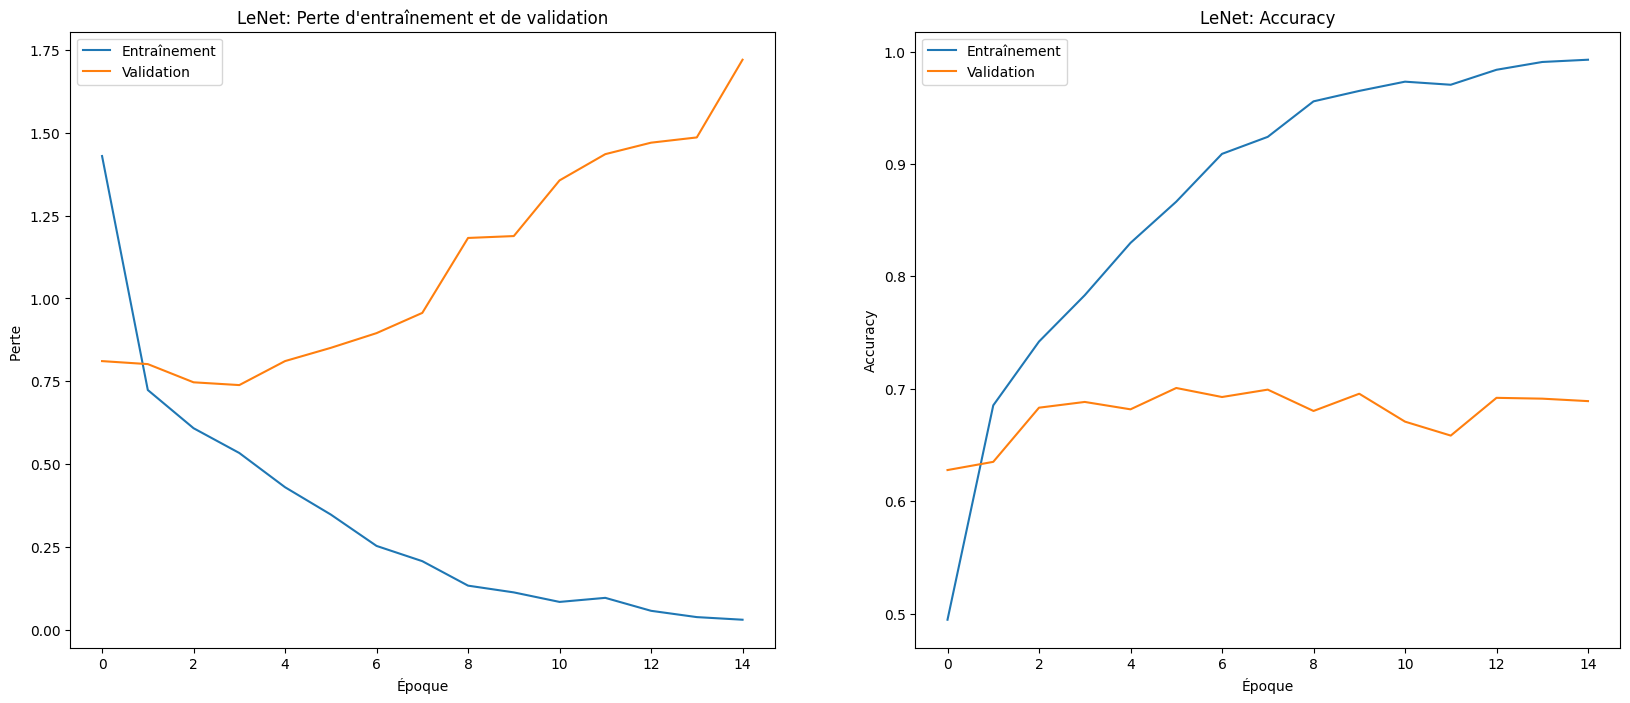

11/11 ━━━━━━━━━━━━━━━━━━━━ -2s -199868us/step - accuracy: 0.7106 - loss: 0.6967
Précision de validation finale: 0.7080


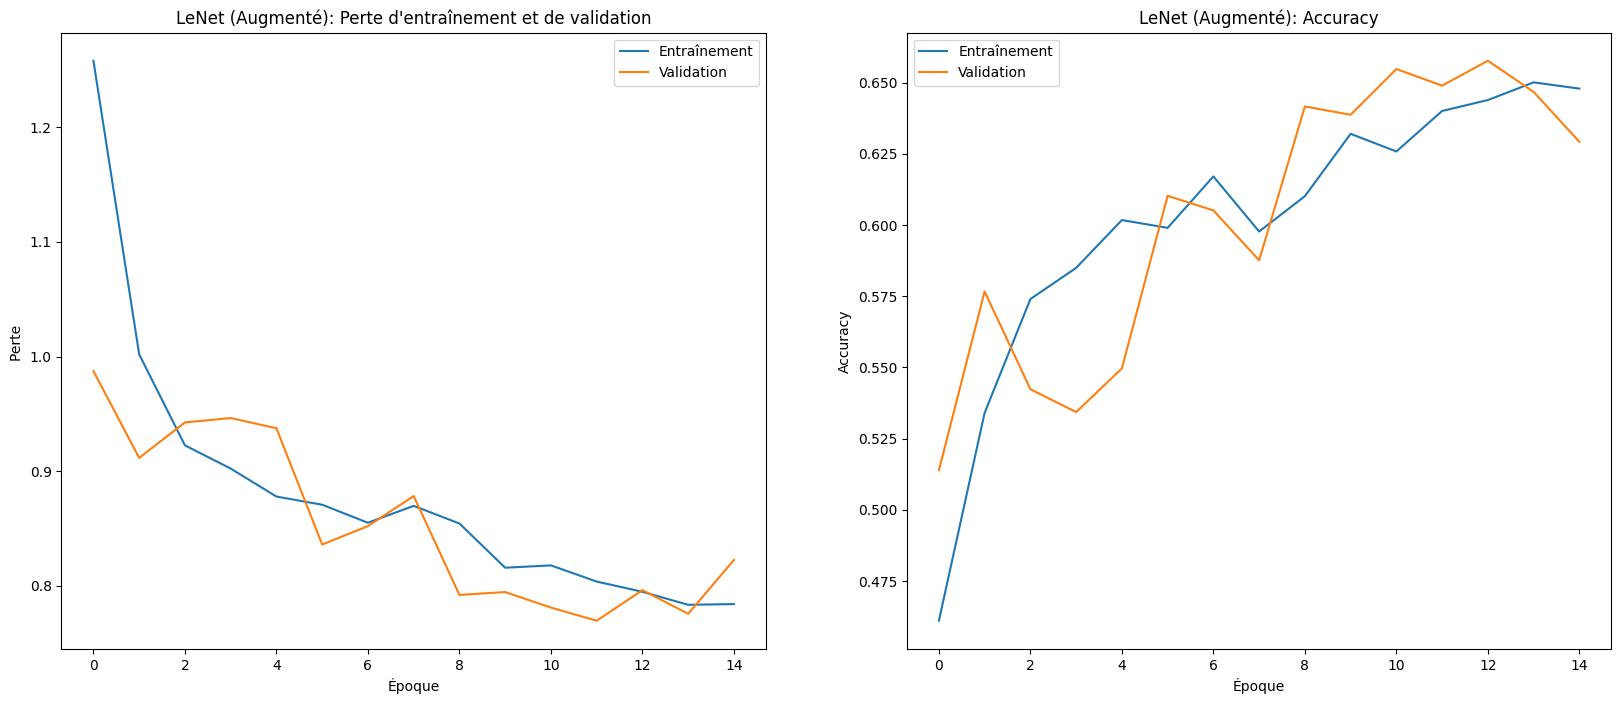

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.7037 - loss: 0.7010 
Précision de validation finale: 0.7073


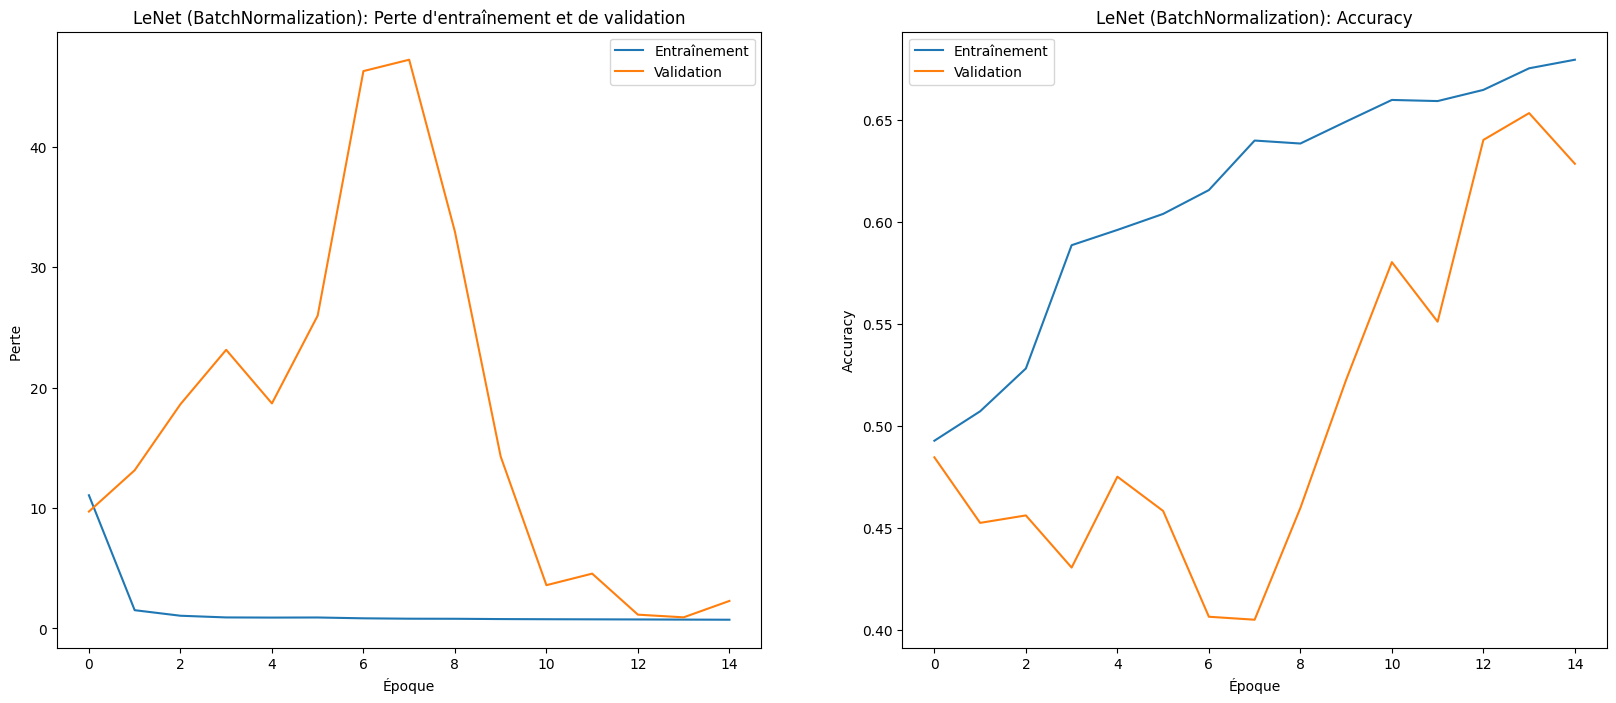

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.2654 - loss: 112.2066 
Précision de validation finale: 0.2766


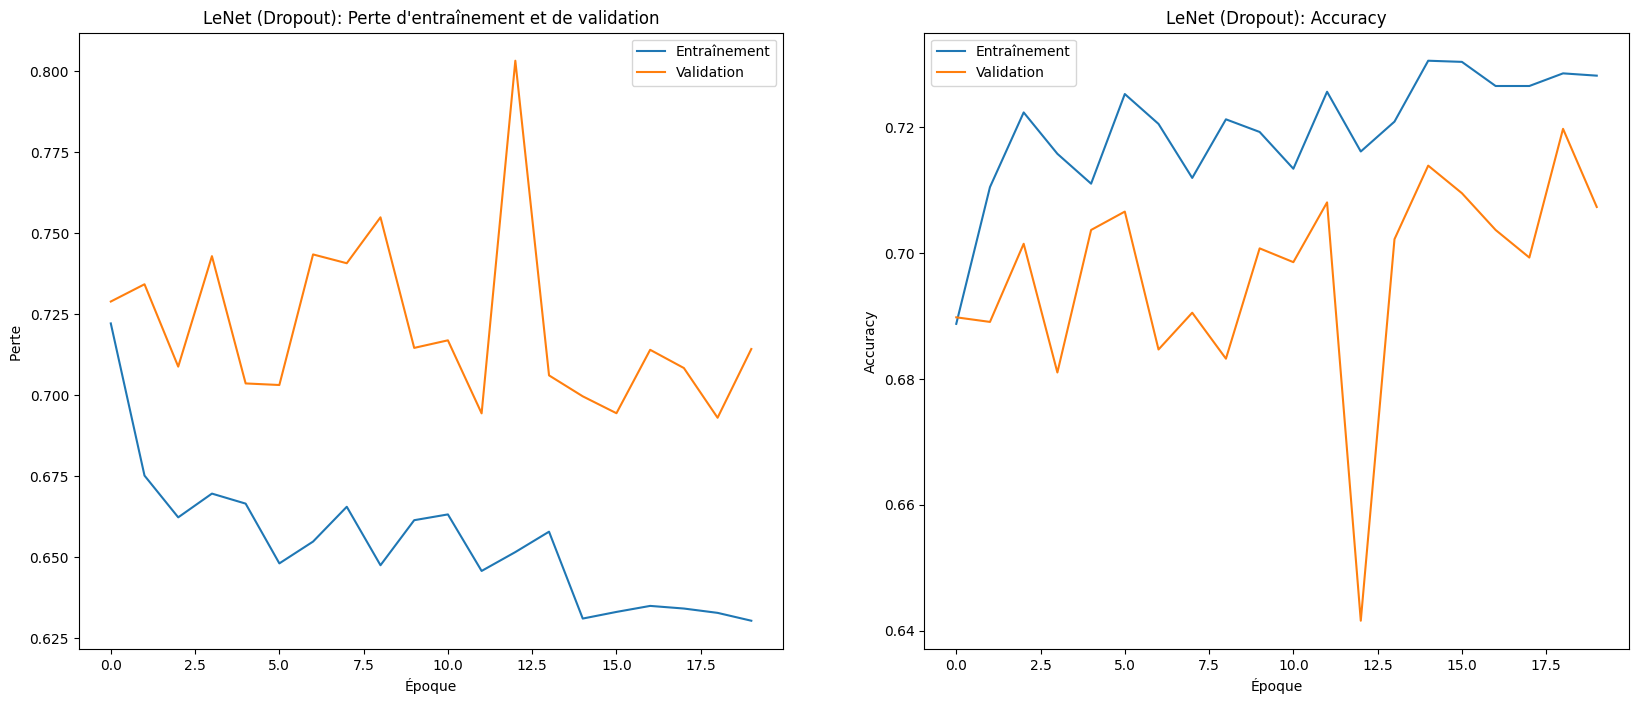

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.7026 - loss: 0.7233 
Précision de validation finale: 0.7073


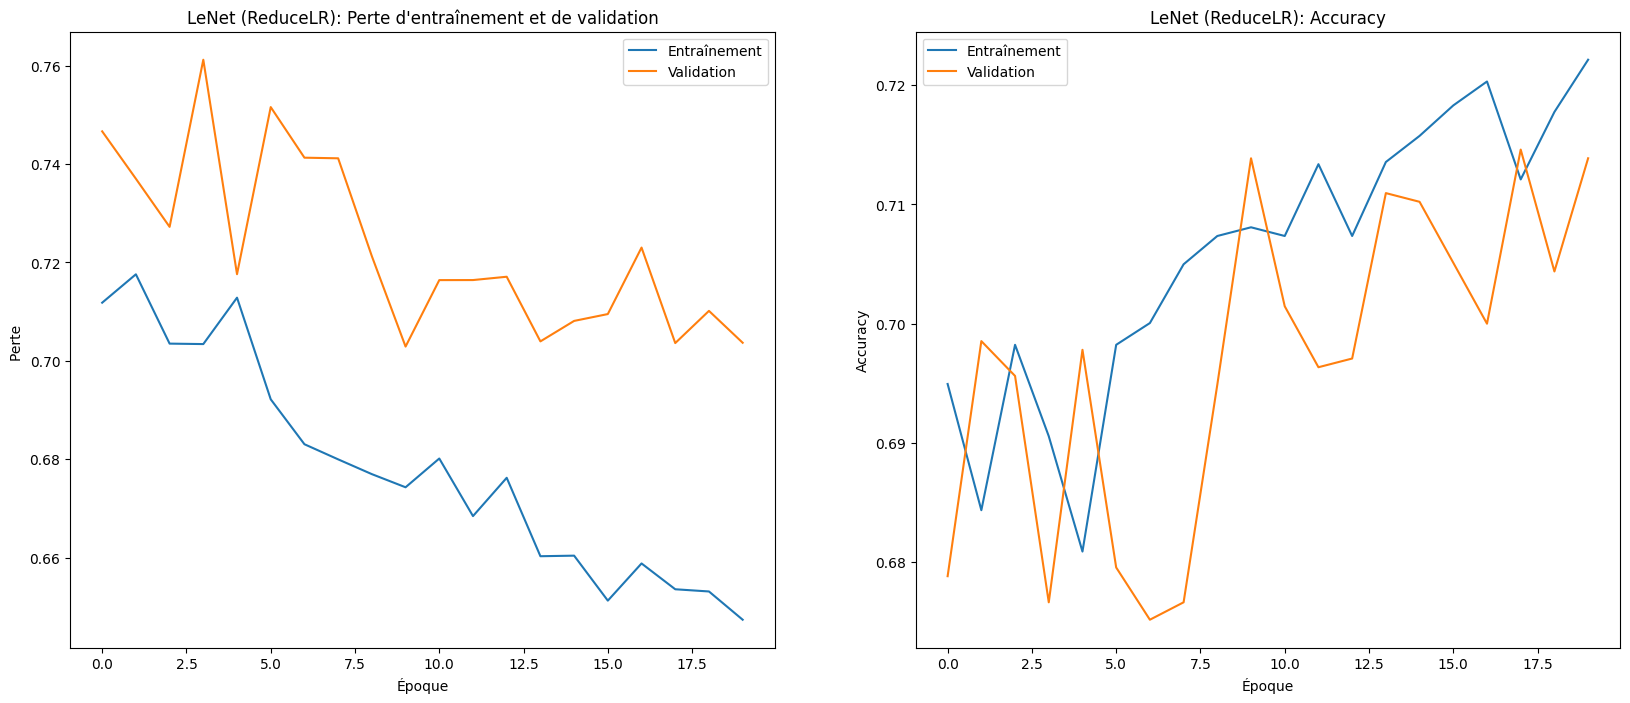

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.7034 - loss: 0.7561 
Précision de validation finale: 0.7073


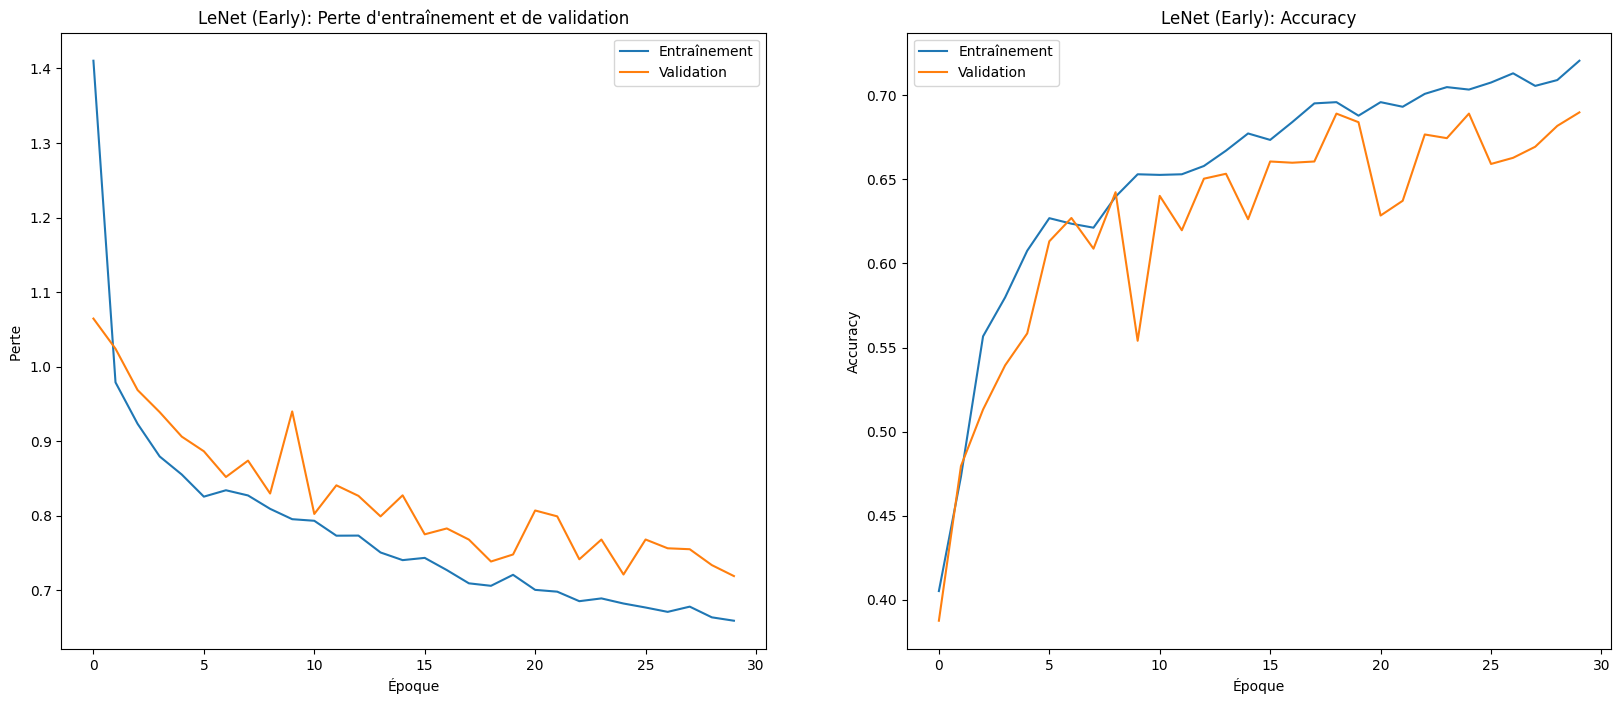

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.6855 - loss: 0.7125 
Précision de validation finale: 0.6891


In [23]:
def display_results(model_history, model_name):
    # Récupérer les données d'entraînement et de validation
    train_loss = model_history.history["loss"]
    val_loss = model_history.history["val_loss"]
    train_accuracy =  model_history.history["accuracy"]
    val_accuracy = model_history.history["val_accuracy"]
    
    plt.figure(figsize=(20, 8))
    
    # Tracer la perte
    plt.subplot(121)
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.title(model_name + ": Perte d'entraînement et de validation")
    plt.ylabel('Perte ')
    plt.xlabel('Époque')
    plt.legend(['Entraînement', 'Validation'], loc='best')
    
    # Tracer l'erreur absolue moyenne (MAE)
    plt.subplot(122)
    plt.plot(train_accuracy)
    plt.plot(val_accuracy)
    plt.title(model_name+': Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Époque')
    plt.legend(['Entraînement', 'Validation'], loc='best')
    
    plt.show()
    
    # Évaluation finale sur l'ensemble de validation
    #val_loss, val_accuracy = lenet.evaluate(val_ds)
    #print(f"Précision de validation finale: {val_accuracy:.4f}")

display_results(lenet_history, "LeNet")
val_loss, val_accuracy = lenet.evaluate(val_ds)
print(f"Précision de validation finale: {val_accuracy:.4f}")

display_results(lenet_augmente_history, "LeNet (Augmenté)") 
val_loss, val_accuracy = lenet_augmente.evaluate(val_ds)
print(f"Précision de validation finale: {val_accuracy:.4f}")

display_results(lenet_BatchNormalization_history, "LeNet (BatchNormalization)") 
val_loss, val_accuracy = lenet_BatchNormalization.evaluate(val_ds)
print(f"Précision de validation finale: {val_accuracy:.4f}")

display_results(lenet_dropout_history, "LeNet (Dropout)") 
# Évaluation finale sur l'ensemble de validation
val_loss, val_accuracy = lenet_dropout.evaluate(val_ds)
print(f"Précision de validation finale: {val_accuracy:.4f}")

display_results(lenet_ReduceLR_history, "LeNet (ReduceLR)") 
# Évaluation finale sur l'ensemble de validation
val_loss, val_accuracy = lenet_ReduceLR.evaluate(val_ds)
print(f"Précision de validation finale: {val_accuracy:.4f}")

display_results(lenet_early_history, "LeNet (Early)") 
# Évaluation finale sur l'ensemble de validation
val_loss, val_accuracy = lenet_early.evaluate(val_ds)
print(f"Précision de validation finale: {val_accuracy:.4f}")
